# Project part 2

Aaron

In [1]:
# Imports
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.figure_factory as ff
import plotly.express as px
import random
import seaborn as sns
import scipy.stats as stats
import uuid
from bson import ObjectId
from cassandra.cluster import Cluster
from datetime import datetime
from io import StringIO
from geopy import Nominatim
from meteostat import Hourly, Stations, Point
from pymongoarrow.api import write
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from scipy.fft import dct, idct

# Use a ggplot theme when plotting
plt.style.use("ggplot")

In [2]:
# Connecting to MongoDB
url = (
    "mongodb+srv://medvetslos:"
    + json.load(open("../../.nosync/mongoDB.json"))["pwd"]
    + "@ind320-project.lunku.mongodb.net/?retryWrites=true&w=majority&appName=IND320-project"
)

mdb_client = MongoClient(url, server_api=ServerApi("1"))

try:
    mdb_client.admin.command("ping")
    print("Pinged your deployment. Successfully connected to MongoDB.")
except Exception as exceptionMsg:
    print(exceptionMsg)

database = mdb_client["IND320-project"]  # Retrieving MongoDB collections
municipalities = database[
    "municipalities"
]  # Access the "muncipalities" collection

Pinged your deployment. Successfully connected to MongoDB.


In [3]:
# Set environment variables to make PySpark work
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/"
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"
os.environ["PYSPARK_HADOOP_VERSION"] = "without"

# Spark set up
spark = (
    SparkSession.builder.appName("SparkCassandraApp")
    .config(
        "spark.jars.packages",
        "com.datastax.spark:spark-cassandra-connector_2.12:3.4.1",
    )
    .config("spark.cassandra.connection.host", "localhost")
    .config(
        "spark.sql.extensions",
        "com.datastax.spark.connector.CassandraSparkExtensions",
    )
    .config(
        "spark.sql.catalog.mycatalog",
        "com.datastax.spark.connector.datasource.CassandraCatalog",
    )
    .config("spark.cassandra.connection.port", "9042")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "4g")
    .config("spark.task.maxFailures", "10")
    .config("spark.sql.shuffle.partitions", "200")
    .getOrCreate()
)

keyspace = "ind320_project"

24/11/11 14:14:32 WARN Utils: Your hostname, Aarons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.42.68.16 instead (on interface en0)
24/11/11 14:14:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/aaron/.ivy2/cache
The jars for the packages stored in: /Users/aaron/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fb5a0031-7ae1-4f3b-9b98-80f4661fcc0c;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central


:: loading settings :: url = jar:file:/Users/aaron/Documents/IND320_projects/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-builder;4.13.0 in central
	found org.apache.commons#commons-lang3;3.10 in central
	found com.thoughtworks.paranamer#paranamer;2.8 in central
	found org.scala-lang#scala-reflect;2.12.11 in central
:: resolution report :: resolve 238ms :: artifacts dl 8ms
	:: modules in use:
	com.datastax.oss#java-d

In [4]:
cluster = Cluster(["localhost"], port=9042)
session = cluster.connect()
keyspace = "ind320_project"

# Creating a keyspace in Cassandra
session.execute(
    "CREATE KEYSPACE IF NOT EXISTS"
    + " "
    + keyspace
    + " "
    + "WITH REPLICATION = {'class': 'SimpleStrategy', 'replication_factor': 1};"
)

session.set_keyspace(
    keyspace
)  # Setting the keyspace to be able to retrieve my tables

In [5]:
# Functions from assignment 1:

# Creating a view to Cassandra with PySpark
def create_cassandra_view(view_name: str, table_name: str, keyspace_name: str):
    spark.read.format("org.apache.spark.sql.cassandra").options(
        table=table_name, keyspace=keyspace_name
    ).load().createOrReplaceTempView(view_name)
    print(f"View '{view_name}' created.")


# Creating a create table query for Cassandra.
def create_cassandra_table_query(df, new_table_name, keyspace_name):
    # Define mapping between Pandas and Cassandra datatypes
    dtype_mapping = {
        "int64": "int",
        "float64": "double",
        "object": "text",
        "bool": "boolean",
        "datetime64[ns]": "timestamp",
    }

    # Start constructing the CREATE TABLE query
    query = f"CREATE TABLE IF NOT EXISTS {keyspace_name}.{new_table_name} (\n"

    # Add primary key column with timeuuid
    columns = ["id timeuuid"]

    # Add remaining columns with mapped Cassandra data types
    for col, dtype in df.dtypes.items():
        if col != "id":  # Exclude 'id' to avoid duplication
            cassandra_type = dtype_mapping.get(
                str(dtype), "text"
            )  # Default to 'text' if type is unrecognized
            columns.append(f"{col} {cassandra_type}")

    # Join columns with commas and specify primary key as 'id'
    columns_str = ",\n    ".join(columns)
    query += f"    {columns_str},\n"
    query += "    PRIMARY KEY (id)\n);"

    return query


# Inserting a Pandas DataFrame into Cassandra with PySpark
def insert_to_cassandra(df: pd.DataFrame, table_name: str, keyspace_name: str):
    # Prompt: How can I add a timeuuid 'id' column when inserting into Cassandra with PySpark
    def generate_timeuuid():
        return str(uuid.uuid1())

    timeuuid_udf = udf(generate_timeuuid, StringType())
    spark.createDataFrame(df).withColumn("id", timeuuid_udf()).write.format(
        "org.apache.spark.sql.cassandra"
    ).mode("append").options(table=table_name, keyspace=keyspace_name).save()

    print("Insertion completed!")

In [ ]:
create_cassandra_view("production_view", "production", keyspace)

View 'production_view' created.


In [12]:
df_production = spark.sql("SELECT * FROM production_view").toPandas()
df_production.columns

Index(['id', 'hourdk', 'hourutc', 'municipalityno', 'offshorewindge100mw_mwh',
       'offshorewindlt100mw_mwh', 'onshorewindmwh', 'solarmwh',
       'thermalpowermwh'],
      dtype='object')

In [20]:
df_production.query("municipalityno==411").query("onshorewindmwh > 0")

,id,hourdk,hourutc,municipalityno,offshorewindge100mw_mwh,offshorewindlt100mw_mwh,onshorewindmwh,solarmwh,thermalpowermwh


### Geographical locations of municipalities

In [ ]:
# Define price_areas based off of energidataservice.dk's definition:
# "DK1 is west of the Great Belt and DK2 is east of the Great Belt."
# https://www.energidataservice.dk/tso-electricity/productionconsumptionsettlement

price_areas = {
    "DK1": ["North", "Central", "South"],
    "DK2": ["Zealand", "Capital"],
}

dk2 = ["Zealand", "Capital"]

nominatim = Nominatim(
    user_agent="personal-application, project"
)  # Initialize a geocoder from GeoPy

# Retrieve only "Region" and "Municipality" from the MongoDB collection
region_municipality = municipalities.find({}, {"Region": 1, "Municipality": 1})

# Iterate over every municipality
for row in region_municipality:
    _id = row["_id"]

    # # Set price area
    # if row["Region"] in price_areas["DK2"]:
    #     price_area = "DK2"
    # else:
    #     price_area = "DK1"

    # Set price area
    if row["Region"] in dk2:
        price_area = "DK2"
    else:
        price_area = "DK1"

    # Find longitude and latitude of the municipality
    geocode_location = nominatim.geocode(row["Municipality"] + " kommune")
    longitude = geocode_location.longitude
    latitude = geocode_location.latitude

    # Update the MongoDB entry with new values
    update_template = {
        "$set": {
            "Price Area": price_area,
            "Longitude": longitude,
            "Latitude": latitude,
        }
    }
    municipalities.update_one({"_id": _id}, update_template)

### Weather data

In [ ]:
# Defining time period we want data from
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31, 23, 59)

# Initialize a MeteoStat station object
stations = Stations()

df_weather = pd.DataFrame()

municipality_coords = municipalities.find(
    {}, {"Municipality": 1, "Longitude": 1, "Latitude": 1}
)

for row in municipality_coords:
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    nearby_stations = stations.nearby(latitude, longitude)
    nearest_station = nearby_stations.fetch(
        1
    )  # Fetches nearest station to the coordinates given
    distance = nearest_station["distance"].iloc[
        0
    ]  # Returns distance to nearest station

    weather_location = Hourly(
        Point(latitude, longitude), start, end
    )  # Fetches hourly weather data for the nearest station during the defined period
    weather_data = (
        weather_location.fetch()
    )  # Retrieves hourly weather data for specified period
    weather_data["distance_to_station"] = (
        distance  # Creating a column for the distance
    )
    weather_data["municipality"] = row[
        "Municipality"
    ]  # Adding a "municipality" column so we can distinguish the data

    df_weather = pd.concat(
        [df_weather, weather_data]
    )  # Concatenating the weather data subsequently

df_weather = df_weather.reset_index()
df_weather = df_weather.rename(columns={"index": "datetime"})

In [10]:
df_weather

,datetime,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,distance_to_station,municipality
0,2022-01-01 00:00:00,7.5,7.2,98.0,0.0,NaN,275.0,16.9,33.1,1012.4,NaN,5.0,2336.324166,Copenhagen
1,2022-01-01 01:00:00,7.4,7.3,99.0,0.0,NaN,277.0,16.2,32.8,1013.1,NaN,5.0,2336.324166,Copenhagen
2,2022-01-01 02:00:00,7.3,7.2,99.0,0.0,NaN,285.0,15.8,31.3,1013.5,NaN,5.0,2336.324166,Copenhagen
3,2022-01-01 03:00:00,7.2,6.9,98.0,0.0,NaN,290.0,18.4,36.0,1013.9,NaN,5.0,2336.324166,Copenhagen
4,2022-01-01 04:00:00,7.5,6.9,96.0,0.0,NaN,291.0,20.2,40.0,1014.3,NaN,5.0,2336.324166,Copenhagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762115,2022-12-31 19:00:00,8.0,8.0,100.0,1.2,NaN,180.0,7.6,20.4,1000.0,NaN,8.0,16705.854121,Fanø
762116,2022-12-31 20:00:00,7.0,7.0,100.0,1.0,NaN,170.0,9.4,18.5,999.0,NaN,9.0,16705.854121,Fanø
762117,2022-12-31 21:00:00,7.0,6.9,99.0,0.0,NaN,120.0,5.4,22.2,999.6,NaN,9.0,16705.854121,Fanø
762118,2022-12-31 22:00:00,7.0,7.0,100.0,1.0,NaN,80.0,5.4,14.8,998.0,NaN,8.0,16705.854121,Fanø


In [ ]:
cas_weather_table = "weather_data"  # Defining a name for my Cassandra table
session.execute(
    f"DROP TABLE IF EXISTS {keyspace}.{cas_weather_table}"
)  # Executing DROP TABLE
weather_table = create_cassandra_table_query(
    df_weather, cas_weather_table, keyspace
)  # Creating a CREATE TABLE query based off of the DataFrame df_weather
session.execute(weather_table)
insert_to_cassandra(df_weather, cas_weather_table, keyspace)

24/11/01 15:32:34 WARN TaskSetManager: Stage 0 contains a task of very large size (8194 KiB). The maximum recommended task size is 1000 KiB.


Insertion completed!


## Smoothing and outliers/anomalies

### Gas prices

In [ ]:
# Get gas prices from the MongoDB collection "gas"
gas_prices = [
    entry
    for entry in database["gas"].find(
        {}, {"PurchasePriceDKK_kWh": 1, "GasDay": 1}
    )
]

df_gas_prices = pd.DataFrame.from_records(
    gas_prices
)  # Make a DataFrame from the list of gas prices
df_gas_prices = df_gas_prices.sort_values(
    "GasDay", ascending=True
)  # Sort the dataframe in temporal order
df_gas_prices.head()

,_id,GasDay,PurchasePriceDKK_kWh
91,6709103c43f4e1efbf67a110,2022-10-01,1.2209
90,6709103c43f4e1efbf67a10f,2022-10-02,1.1672
89,6709103c43f4e1efbf67a10e,2022-10-03,1.0476
88,6709103c43f4e1efbf67a10d,2022-10-04,0.8667
87,6709103c43f4e1efbf67a10c,2022-10-05,0.6087


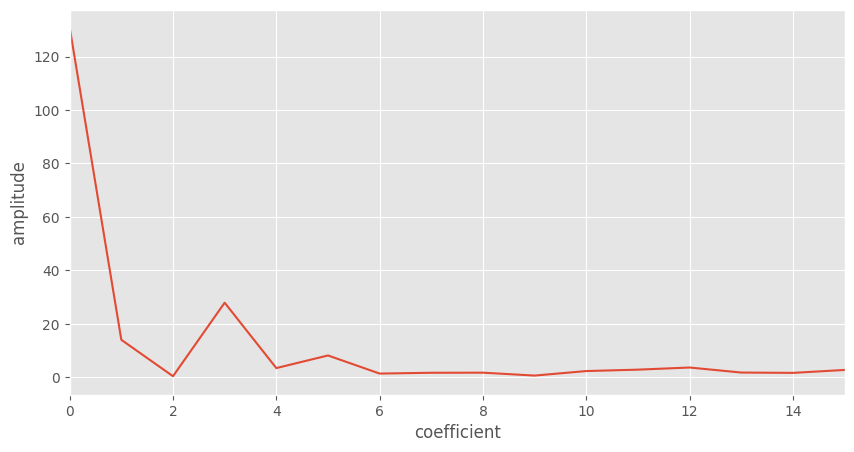

In [ ]:
W = np.arange(0, df_gas_prices.shape[0])
dct_gas_prices = dct(
    df_gas_prices["PurchasePriceDKK_kWh"].values
)  # DCT on the gas prices

# Plotting of the DCT
num_coeff = 15

plt.figure(figsize=(10, 5))
plt.plot(np.abs(dct_gas_prices))
plt.xlabel("coefficient")
plt.ylabel("amplitude")
# plt.xlim(0, dct_gas_prices.shape[0])
plt.xlim(0, num_coeff)
plt.xticks(np.arange(0, num_coeff + 1, step=2))
plt.show()

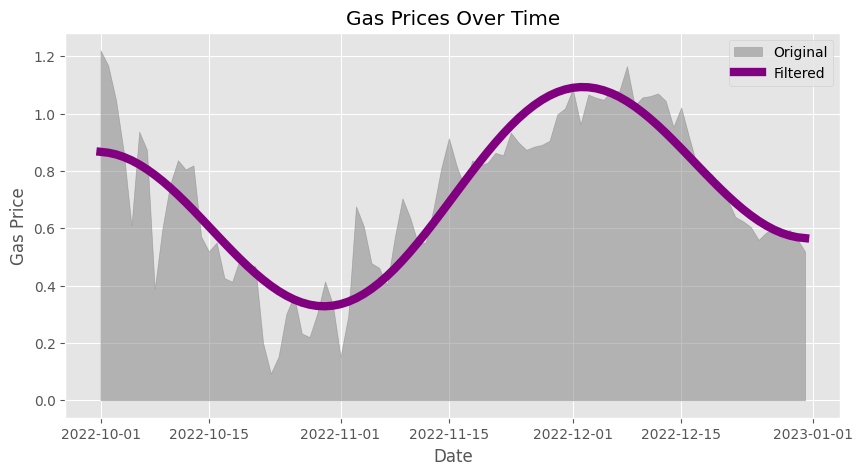

In [ ]:
dct_gas_prices[(W > 3)] = 0  # Filter out frequencies greater than 3

plt.figure(figsize=(10, 5))
plt.fill_between(
    df_gas_prices["GasDay"],
    df_gas_prices["PurchasePriceDKK_kWh"],
    color="grey",
    alpha=0.5,
    label="Original",
)
plt.xlabel("Date")
plt.ylabel("Gas Price")
plt.title("Gas Prices Over Time")
plt.plot(
    df_gas_prices["GasDay"],
    idct(dct_gas_prices),
    label="Filtered",
    color="purple",
    linewidth=6,
)
plt.legend()
plt.show()

### Electricity exchange

In [ ]:
create_cassandra_view(
    "prodcons_view", "prodcons", keyspace
)  # Create a view to access the "prodcons" table
df_exchangeNO = spark.sql(
    "SELECT hourdk, exchangeno_mwh FROM prodcons_view"
).toPandas()
df_exchangeNO = df_exchangeNO.groupby("hourdk").aggregate(
    {"exchangeno_mwh": "sum"}
)  # Aggregate sum such that we get the total exchange for DK1 and DK2

# Mean and standard deviation of the electricity exchange
mean_exchangeNO = df_exchangeNO["exchangeno_mwh"].mean()
std_exchangeNO = df_exchangeNO["exchangeno_mwh"].std()
print(f"Mean: {mean_exchangeNO:.1f}")
print(f"Standard deviation: {std_exchangeNO:.1f}")

24/11/01 15:32:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


View 'prodcons_view' created.
Mean: 228.6
Standard deviation: 1013.0


In 2022, the danes on average imported $228.6\ MWh$ of energy a day from Norway with a standard deviation of $1013\ MWh$. The standard deviation is big as it constantly jumps between importing and exporting energy. 

In [ ]:
# Robust statistics
k = 1.4826  # k with the assumption that our data is normally distributed
trim_mean_exchangeNO = stats.trim_mean(
    df_exchangeNO["exchangeno_mwh"], 0.05
)  # Trimmed mean removing 5% of the most extreme observations
MAD_exchangeNO = stats.median_abs_deviation(df_exchangeNO["exchangeno_mwh"])
print(f"Trimmed mean: {trim_mean_exchangeNO:.3f}")
print(f"MAD: {MAD_exchangeNO:.3f}")
print(f"Adjusted MAD: {MAD_exchangeNO * k:.3f}")

Trimmed mean: 256.473
MAD: 694.875
Adjusted MAD: 1030.222



Trimmed mean is different from the normal mean statistic as we remove a percentage of the most extreme observations, here 5%. Since we are removing a proportion, the number of samples becomes smaller which results in a "bigger" mean value than the original mean.

Median absolute devation differs from standard deviation, but it has a relation to it by multiplying it by $k \approx 1.4826$ if we assume that our data is normally distributed. By multiplying by $k$ we get a value more similair to the standard deviation $\hat{\sigma}$ approximated above. We see that our adjusted $MAD$-value differs slightly from the standard deviation we estimated above.

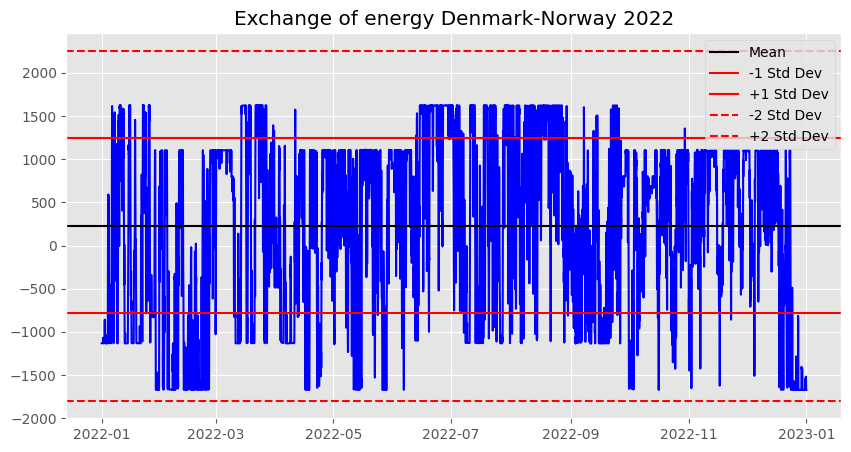

In [ ]:
# Plotting the gas prices with standard deviations and mean
plt.figure(figsize=(10, 5))
plt.plot(df_exchangeNO.index, df_exchangeNO["exchangeno_mwh"], color="blue")
plt.title("Exchange of energy Denmark-Norway 2022")
plt.axhline(mean_exchangeNO, color="black", label="Mean")
plt.axhline(mean_exchangeNO - std_exchangeNO, color="red", label="-1 Std Dev")
plt.axhline(mean_exchangeNO + std_exchangeNO, color="red", label="+1 Std Dev")
plt.axhline(
    mean_exchangeNO - 2 * std_exchangeNO,
    color="red",
    linestyle="--",
    label="-2 Std Dev",
)
plt.axhline(
    mean_exchangeNO + 2 * std_exchangeNO,
    color="red",
    linestyle="--",
    label="+2 Std Dev",
)
plt.legend()
plt.show()

In [18]:
# Calculating +- 3 Standard deviations
upper_spc = mean_exchangeNO + 3 * std_exchangeNO
lower_spc = mean_exchangeNO - 3 * std_exchangeNO

print(f"{lower_spc:.1f}", f"{upper_spc:.1f}")

-2810.4 3267.5


If we assume any measurement outside $\pm 3$ to be an outlier, the export of energy has to be greater than $2810.4\ MWh$ or the import has to be greater than $3267.5\ MWh$ before we flag it.

## Imputation

In [ ]:
# Get gas prices from my MongoDB collection "gas"
gas_prices = [entry for entry in database["gas"].find()]

# Create views to access my Cassandra tables
create_cassandra_view("prodcons_view", "prodcons", keyspace)
create_cassandra_view("production_view", "production", keyspace)
create_cassandra_view("consumption_view", "consumption", keyspace)
create_cassandra_view("weather_view", "weather_data", keyspace)

# Retrieve and prepare DataFrames
df_municipalities = pd.DataFrame.from_records(
    [entry for entry in municipalities.find({})]
)
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_prodcons = spark.sql("SELECT * FROM prodcons_view").toPandas()
df_production = spark.sql("SELECT * FROM production_view").toPandas()
df_consumption = spark.sql("SELECT * FROM consumption_view").toPandas()
df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()

24/11/08 18:18:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


View 'prodcons_view' created.
View 'production_view' created.
View 'consumption_view' created.
View 'weather_view' created.


### Checking for missing values in each dataframe

In [ ]:
dfs = {
    "gas_prices": df_gas_prices,
    "prodcons": df_prodcons,
    "production": df_production,
    "consumption": df_consumption,
    "weather_data": df_weather_data,
    "municipalities": df_municipalities,
}

for key, df in dfs.items():
    na_df = df.isna().sum()  # Get sum of NAs for every column of the DataFrame
    non_zero_na_df = na_df[
        na_df > 0
    ]  # Filter out the columns that does not have NAs

    # Print out a summary of missing values in a DataFrame if there is any
    if not non_zero_na_df.empty:
        print(f"\n{key} - {df.shape}:")
        print(non_zero_na_df)


gas_prices - (92, 13):
EEXHighestPricePurchaseDKK_kWh    70
EEXLowestPriceSaleDKK_kWh         64
dtype: int64

prodcons - (17520, 29):
exchangegb_mwh    17520
exchangenl_mwh     8760
exchangeno_mwh     8760
dtype: int64

production - (871393, 9):
offshorewindge100mw_mwh    818834
offshorewindlt100mw_mwh    801313
solarmwh                     8760
thermalpowermwh            123888
dtype: int64

weather_data - (762120, 15):
coco     48361
dwpt      2658
prcp    158466
pres      2658
rhum      2658
snow    718431
temp      2658
tsun    720638
wdir      2661
wpgt      2723
wspd      2658
dtype: int64


In [5]:
# A function to create an overview of the number and proportion missing
# values in a DataFrame
def na_overview(df: pd.DataFrame):
    na_df = df.isna().sum()
    na_df = na_df[na_df > 0].to_frame(name="# missing values")
    na_df["% missing values"] = na_df["# missing values"] / df.shape[0]
    print(df.shape)
    return na_df

#### Gas prices

In [9]:
gas_prices = [entry for entry in database["gas"].find()]
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_gas_prices = df_gas_prices.sort_values("GasDay", ascending=True)

In [10]:
na_gas = na_overview(df_gas_prices)
na_gas

(92, 13)


,# missing values,% missing values
EEXHighestPricePurchaseDKK_kWh,70,0.760870
EEXLowestPriceSaleDKK_kWh,64,0.695652


In [11]:
df_gas_prices.head()

,_id,GasDay,EEXSpotIndexEUR_MWh,EEXWithinDayEUR_MWh,ExchangeRateEUR_DKK,SalesPriceDKK_kWh,PurchasePriceDKK_kWh,NeutralGasPriceDKK_kWh,EEXHighestPricePurchaseDKK_kWh,EEXLowestPriceSaleDKK_kWh,MarginalSalePriceDKK_kWh,MarginalPurchasePriceDKK_kWh,THEPriceDKK_kWh
91,6732429db2181cbdd478fd78,2022-10-01,168.168,165.000,743.65,1.2332,1.2209,1.2270,NaN,NaN,1.2332,1.2209,1.2239
90,6732429db2181cbdd478fd77,2022-10-02,168.168,157.742,743.65,1.1789,1.1672,1.1730,NaN,NaN,1.1789,1.1672,1.2239
89,6732429db2181cbdd478fd76,2022-10-03,167.210,141.581,743.66,1.0581,1.0476,1.0529,NaN,NaN,1.0581,1.0476,1.2203
88,6732429db2181cbdd478fd75,2022-10-04,147.942,117.112,743.74,0.8754,0.8667,0.8710,NaN,0.3719,0.8754,0.3719,1.0478
87,6732429db2181cbdd478fd74,2022-10-05,119.772,82.244,743.88,0.6149,0.6087,0.6118,NaN,NaN,0.6149,0.6087,0.7978


In [12]:
def plot_NA(df: pd.DataFrame, value_column: str, time_column: str):
    df = df.copy()
    df.set_index(time_column, inplace=True)

    df_not_null = df[value_column].notnull()

    plt.figure(figsize=(10, 5))
    plt.vlines(df_not_null.index, ymin=0, ymax=1, 
               colors=df_not_null.map({True: 'black', False: 'white'}), 
               linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Presence of Data')
    plt.title(f'Presence of {value_column} Over Time')
    plt.show()

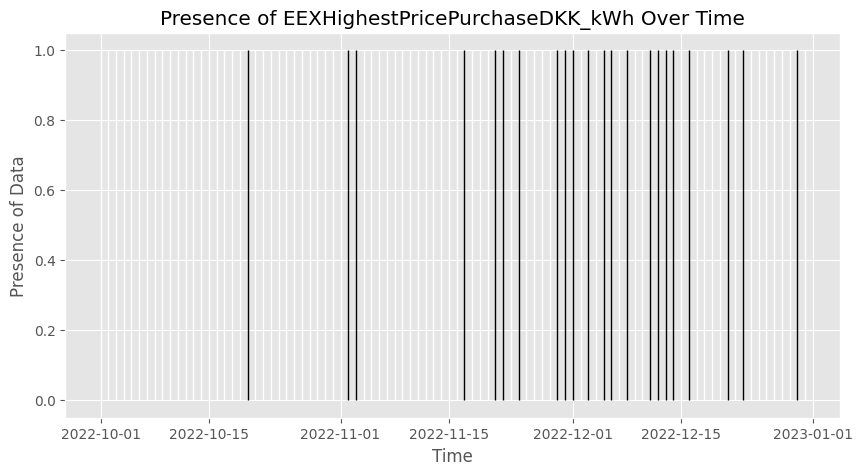

In [13]:
plot_NA(df_gas_prices, "EEXHighestPricePurchaseDKK_kWh", "GasDay")

In [17]:
na_gas = na_overview(df_gas_prices)
na_gas

(92, 13)


,# missing values,% missing values
EEXHighestPricePurchaseDKK_kWh,70,0.760870
EEXLowestPriceSaleDKK_kWh,64,0.695652


In [ ]:
    # # Rolling average
    # for col in impute_cols:
    #     temp_df[col] = temp_df[col].fillna(temp_df[col].rolling(window=365, 
    #                                                             min_periods=1).mean())

In [33]:
from bson import ObjectId

gas_prices = [entry for entry in database["gas"].find()]
df_gas_prices = pd.DataFrame.from_records(gas_prices)
df_gas_prices = df_gas_prices.sort_values("GasDay", ascending=True)

df_gas_prices["EEXHighestPricePurchaseDKK_kWh"] = df_gas_prices[
    "EEXHighestPricePurchaseDKK_kWh"
].fillna(df_gas_prices["EEXHighestPricePurchaseDKK_kWh"].rolling(window=3, min_periods=1).mean())

df_gas_prices["EEXLowestPriceSaleDKK_kWh"] = df_gas_prices[
    "EEXLowestPriceSaleDKK_kWh"
].fillna(df_gas_prices["EEXLowestPriceSaleDKK_kWh"].rolling(window=3, min_periods=1).mean())

# df_gas_prices["_id"] = (
#     df_gas_prices["_id"].apply(lambda x: ObjectId(x)).astype(str)
# )

# write(database["gas"], df_gas_prices)

In [34]:
na_gas = na_overview(df_gas_prices)
na_gas

(92, 13)


,# missing values,% missing values
EEXHighestPricePurchaseDKK_kWh,49,0.532609
EEXLowestPriceSaleDKK_kWh,40,0.434783


#### Prodcons

In [16]:
# Get an overview of the number and proportion of missing values
na_prodcons = na_overview(df_prodcons)
na_prodcons

NameError: name 'df_prodcons' is not defined

In [ ]:
# Trying to assess a pattern as the missing values makes out either half
# of the dataset or its entire length
df_prodcons_na = df_prodcons[
    [
        "hourdk",
        "pricearea",
        "exchangeno_mwh",
        "exchangenl_mwh",
        "exchangegb_mwh",
    ]
].copy()
df_prodcons_na = df_prodcons_na.sort_values("hourdk", ascending=True)
df_prodcons_na.head(8)

,hourdk,pricearea,exchangeno_mwh,exchangenl_mwh,exchangegb_mwh
11233,2022-01-01 00:00:00,DK1,-1131.8420,-621.410,NaN
7560,2022-01-01 00:00:00,DK2,NaN,NaN,NaN
10268,2022-01-01 01:00:00,DK1,-1132.2717,-583.754,NaN
7045,2022-01-01 01:00:00,DK2,NaN,NaN,NaN
1524,2022-01-01 02:00:00,DK1,-1132.2246,-554.725,NaN
6615,2022-01-01 02:00:00,DK2,NaN,NaN,NaN
7036,2022-01-01 03:00:00,DK1,-1132.4853,-237.741,NaN
17046,2022-01-01 03:00:00,DK2,NaN,NaN,NaN


In [ ]:
# Checking if the Netherlands and Norway only exchange energy with pricearea
# DK2 during this period. If they happen to  do so, we should see "False"
# printed out.
print(
    df_prodcons[df_prodcons["exchangeno_mwh"].notna()]
    .query("pricearea == 'DK2'")
    .empty
)
print(
    df_prodcons[df_prodcons["exchangenl_mwh"].notna()]
    .query("pricearea == 'DK2'")
    .empty
)

True
True


For **prodcons** we have missing data for the exchange of energy to Great Britain, the Netherlands and Norway. Great Britain has no import or export of energy during the period of our data, hence 17520 total missing values. For both the Netherlands and Norway we have half of the missing values as Great Britain. This can be attributed to these countries only exchanging energy with `pricearea` "DK1". We can interperet the NaNs as lack of activity during this period.

Imputing any of these missing values would not be appropriate.

In [ ]:
df_prodcons = df_prodcons.fillna(0)
na_overview

#### Production

In [39]:
# Get an overview of the number and proportion of missing values
df_production = spark.sql("SELECT * FROM production_view").toPandas()
na_production = na_overview(df_production)
na_production

(871393, 9)


,# missing values,% missing values
offshorewindge100mw_mwh,818834,0.939684
offshorewindlt100mw_mwh,801313,0.919577
solarmwh,8760,0.010053
thermalpowermwh,123888,0.142172


**production** is missing quite a lot of data in its offshore wind production, both missing more than 90% of data. The fraction of values missing would not be appropriate to impute.

However, solar and thermal energy production is missing less data which would be more feasible to impute.

In [ ]:
# Group by municipality to check misising values
na_municipality = df_production.groupby("municipalityno").apply(
    lambda x: x.isna().sum()
)

na_municipality


,id,hourdk,hourutc,municipalityno,offshorewindge100mw_mwh,offshorewindlt100mw_mwh,onshorewindmwh,solarmwh,thermalpowermwh
municipalityno,,,,,,,,,
101,0,0,0,0,8760,0,0,0,0
147,0,0,0,0,8760,8760,0,0,8760
151,0,0,0,0,8760,8760,0,0,0
153,0,0,0,0,8760,8760,0,0,0
155,0,0,0,0,8760,8760,0,0,8760
...,...,...,...,...,...,...,...,...,...
846,0,0,0,0,8760,8760,0,0,0
849,0,0,0,0,8760,8760,0,0,0
851,0,0,0,0,8760,8760,0,0,0


In [ ]:
filtered_na_municipality = na_municipality[(na_municipality > 0)].dropna(
    how="all"
)

# Number of municipalities missing measurements for the entire period
# for the different production types
for production_type in filtered_na_municipality.columns[4:]:
    print(
        f"{production_type}:",
        len(filtered_na_municipality.query(f"{production_type} == 8760")),
    )

offshorewindge100mw_mwh: 93
offshorewindlt100mw_mwh: 91
onshorewindmwh: 0
solarmwh: 1
thermalpowermwh: 13


93 and 91 municipalities are missing offshore wind production, 1 is missing solar production and 13 thermal power production during the entire period. For these municipalities, setting the missing values to 0 would be appropriate.

In [ ]:
df_production_copy = df_production.copy()

for production_type in df_production_copy.columns[4:]:
    temp_df = na_municipality.query(f"{production_type} == 8760")

    municipality_no = temp_df.index.tolist()

    # Prompt: How can I select the municipalities from municipality_no in
    # df_production_copy to then set all of the NaN values of the
    # production_type to 0?
    df_production_copy.loc[
        df_production_copy["municipalityno"].isin(municipality_no),
        production_type,
    ] = df_production_copy.loc[
        df_production_copy["municipalityno"].isin(municipality_no),
        production_type,
    ].fillna(0)

In [105]:
na_overview(df_production_copy)

(871393, 9)


,# missing values,% missing values
offshorewindge100mw_mwh,4154,0.004767
offshorewindlt100mw_mwh,4153,0.004766
thermalpowermwh,10008,0.011485


In [ ]:
# Check which municipalities the remaining missing values belong to
na_municipality_2 = df_production_copy.groupby("municipalityno").apply(
    lambda x: x.isna().sum()
)
na_municipality_2 = na_municipality_2[na_municipality_2 > 0].dropna(how="all")
na_municipality_2

,id,hourdk,hourutc,municipalityno,offshorewindge100mw_mwh,offshorewindlt100mw_mwh,onshorewindmwh,solarmwh,thermalpowermwh
municipalityno,,,,,,,,,
360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5855.0
411,NaN,NaN,NaN,NaN,4153.0,4153.0,NaN,NaN,4153.0
665,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
df_production_copy.reset_index(inplace=True)
df_production_copy.set_index("hourdk", inplace=True)

df_production_copy = df_production_copy.select_dtypes(
    include=["number"]
).interpolate("time")

na_overview(df_production_copy)

(871393, 6)


,# missing values,% missing values


#### Weather data (old)

In [ ]:
# # Checking the number and proportion of missing values in the weather DataFrame
# na_weather = na_overview(df_weather_data)
# na_weather

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
dwpt,2658,0.003488
prcp,158466,0.207928
pres,2658,0.003488
rhum,2658,0.003488
snow,718431,0.942674
temp,2658,0.003488
tsun,720638,0.945570
wdir,2661,0.003492
wpgt,2723,0.003573


In [ ]:
# # Finding the stations where "snow" and "tsun" is being measured to assess
# # why there are many missing values
# df_snow = df_weather_data[df_weather_data["snow"].notna()]
# df_tsun = df_weather_data[df_weather_data["tsun"].notna()]
# print(df_snow["municipality"].unique())
# print(df_tsun["municipality"].unique())

['Sønderborg' 'Lolland' 'Ærø' 'Aabenraa' 'Tønder']
['Sønderborg' 'Lolland' 'Aabenraa' 'Ærø' 'Tønder']


In [ ]:
# # Check if there are any missing values for the locations which measures `snow` and `tsun`
# tsun_snow_locations = df_snow["municipality"].unique()
# df_tsun_snow = df_weather_data[df_weather_data["municipality"].isin(tsun_snow_locations)]
# df_tsun_snow_na = df_tsun_snow.isna().sum()
# df_tsun_snow_na[df_tsun_snow_na> 0]

snow     111
tsun    2318
dtype: int64

**weather_data** is missing a lot of data for `snow` which at first glance is sensible since there isn't snow all year round. But upon further investigation, `snow` is only measured at a handful of stations. This is also the case for `tsun` which is measured at the same stations, hence the big number of missing values. Having to impute this for the rest of the stations would be unreasonable as no measurements exists at these locations. 

In [ ]:
# # Retrieve all municipalities with precipitation measurements
# prcp_measured = df_weather_data[df_weather_data["prcp"].notna()]["municipality"].unique()

# # Use the symmetric difference operator "^".
# # Between two sets, it returns values not shared by both sets.
# # In this case we return municipalities which does not measure precipitation at all.
# na_prcp = set(prcp_measured)^set(df_weather_data["municipality"].unique())

# print(na_prcp)

{'Thisted', 'Lemvig', 'Helsingør', 'Morsø', 'Skive', 'Gribskov', 'Halsnæs', 'Vesthimmerland', 'Odsherred', 'Struer'}


The missing values for `prcp` is partly due to 10 stations not measuring percipitation at all. Imputing the precipitation for these stations would not make sense. The remaining missing values comes from stations which do measure percipitation and these we can impute.

`dwpt`, `pres`, `rhum`, and `wspd` are missing the same amount of data.

`coco` is an integer indicating the weather condition as noted in the [documentation](https://dev.meteostat.net/formats.html#weather-condition-codes). Imputing these could give a false indication of the weather. If wanted to impute this, perhaps a LOCF would be sensible as long as the gaps are not long.

For the remaining features it would be reasonable to impute the missing values as the numbers are relatively small.

##### Imputation

In [ ]:
# # Preparing DataFrame for interpolation
# df_weather_data = df_weather_data.sort_values("datetime", ascending=True)
# df_weather_data.set_index("datetime", inplace=True)

In [ ]:
# # Impute `tsun` and `snow` for 'Sønderborg', 'Ærø', 'Lolland', 'Aabenraa' and 'Tønder'

# # Get municipalities which measures `tsun` and `snow`
# loc_snow_tsun = df_weather_data[df_weather_data["tsun"].notna()]["municipality"].unique()

# # Creating a copy with our desired municipalities
# df_snow_tsun = df_weather_data[df_weather_data["municipality"].isin(loc_snow_tsun)].copy()

# # Imputing the values by using "time" in .interpolation
# df_snow_tsun[["snow", "tsun"]] = df_snow_tsun[["snow", "tsun"]].interpolate("time")

# # Replace the existing "snow" and "tsun" measurements with their imputed counterparts
# df_weather_data.loc[df_weather_data["municipality"].isin(loc_snow_tsun),
#                     ["snow", "tsun"]] = df_snow_tsun[["snow", "tsun"]].values

In [ ]:
# # Impute `prcp` for every municipality but 'Morsø', 'Lemvig', 'Helsingør', 'Struer', 'Halsnæs', 'Odsherred', 'Skive', 'Gribskov', 'Thisted' and 'Vesthimmerland'
# exclude_list = list(na_prcp)

# # Excluding municipalities/weather stations that does not measure precipitation
# df_weather_data_prcp = df_weather_data[~df_weather_data["municipality"].isin(exclude_list)].copy()

# # Imputing the values by using "time" in .interpolation
# df_weather_data_prcp["prcp"] = df_weather_data_prcp["prcp"].interpolate("time")

# # Insert the imputed `prcp`-values where they belong
# df_weather_data.loc[~df_weather_data["municipality"].isin(exclude_list), ["prcp"]] = df_weather_data_prcp["prcp"].values

In [ ]:
# # Impute remaining missing values for columns not named `prcp`, `snow`, `tsun` and `coco`

# # Exlcude the following columns from the imputation procedure
# # since we've imputed them as seen above
# exclude_cols = ["prcp", "snow", "tsun", "coco"]

# # Create a copy and impute values
# df_weather_impute = df_weather_data.copy().drop(columns=exclude_cols)
# df_weather_impute = df_weather_impute.interpolate("time")

# # Insert the imputed values to their respective places
# df_weather_data.update(df_weather_impute)
# df_weather_data.reset_index(inplace=True)

In [ ]:
# # Double check to see if have managed to impute values
# # in our desired columns
# na_overview(df_weather_data)

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
prcp,87600,0.114943
snow,718320,0.942529
tsun,718320,0.942529


#### Weather data (new)

In [6]:
create_cassandra_view("weather_view", "weather_data", keyspace)
df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()

View 'weather_view' created.


In [11]:
# Checking the number and proportion of missing values in the weather DataFrame
na_weather = na_overview(df_weather_data)
na_weather

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
dwpt,2658,0.003488
prcp,158466,0.207928
pres,2658,0.003488
rhum,2658,0.003488
snow,718431,0.942674
temp,2658,0.003488
tsun,720638,0.945570
wdir,2661,0.003492
wpgt,2723,0.003573


In [12]:
# To gauge how long a series would be for one municipality
df_weather_data.query("municipality == 'Copenhagen'").shape

(8760, 15)

In [13]:
# df_weather_data = spark.sql("SELECT * FROM weather_view").toPandas()
df_weather_data = df_weather_data.sort_values("datetime", ascending=True)
grouped_weather = df_weather_data.groupby("municipality").apply(
    lambda x: x.isna().sum()
)
grouped_weather

,id,coco,datetime,distance_to_station,dwpt,municipality,prcp,pres,rhum,snow,temp,tsun,wdir,wpgt,wspd
municipality,,,,,,,,,,,,,,,
Aabenraa,0,0,0,0,0,0,0,0,0,97,0,145,0,0,0
Aalborg,0,233,0,0,0,0,3168,0,0,8760,0,8760,0,0,0
Albertslund,0,236,0,0,0,0,17,0,0,8760,0,8760,0,0,0
Allerød,0,236,0,0,0,0,17,0,0,8760,0,8760,0,0,0
Assens,0,246,0,0,0,0,3494,0,0,8760,0,8760,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vejle,0,235,0,0,0,0,3494,0,0,8760,0,8760,0,0,0
Vesthimmerland,0,264,0,0,263,0,8760,263,263,8760,263,8760,263,263,263
Viborg,0,232,0,0,0,0,3168,0,0,8760,0,8760,0,0,0


From a quick glance of looking at the municipalities and its missing values, many of them are a total of 8760 in various columns, making out the entire time series. For these columns and municipalities, imputing data would not be sufficient.

In addition, various municipalities are missing values for `coco` which acts as a categorical variable per Meteostat's documentation so I will refrain from imputing over this column.

In [14]:
grouped_weather[grouped_weather == 8760].dropna(how="all")

,id,coco,datetime,distance_to_station,dwpt,municipality,prcp,pres,rhum,snow,temp,tsun,wdir,wpgt,wspd
municipality,,,,,,,,,,,,,,,
Aalborg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Albertslund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Allerød,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Assens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Ballerup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vejen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Vejle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN
Vesthimmerland,NaN,NaN,NaN,NaN,NaN,NaN,8760.0,NaN,NaN,8760.0,NaN,8760.0,NaN,NaN,NaN


In [15]:
df_weather_data_c = df_weather_data.copy()
df_weather_data_c.set_index("datetime", inplace=True)

window_size = 24

for municipality in df_weather_data["municipality"].unique():
    # Get relevant columns to impute over
    na_weather_count = grouped_weather[grouped_weather.index == municipality]
    impute_cols = na_weather_count.loc[
        :, (na_weather_count != 0).all() & (na_weather_count < 8760).all()
    ]
    impute_cols = impute_cols.drop(
        columns=["coco"], errors="ignore"
    ).columns.tolist()

    # Impute over relevant columns
    temp_df = df_weather_data_c[
        df_weather_data_c["municipality"] == municipality
    ]

    df_weather_data_c.loc[
        df_weather_data_c["municipality"] == municipality, impute_cols
    ] = temp_df[impute_cols].interpolate("time", axis=0)


    # # Rolling average
    # for col in impute_cols:
    #     temp_df[col] = temp_df[col].fillna(temp_df[col].rolling(window=365, 
    #                                                             min_periods=1).mean())

    # df_weather_data_c.loc[
    #     df_weather_data_c["municipality"] == municipality, impute_cols
    # ] = temp_df[impute_cols]

   
df_weather_data_c.reset_index(inplace=True)

In [16]:
na_overview(df_weather_data_c)

(762120, 15)


,# missing values,% missing values
coco,48361,0.063456
prcp,126034,0.165373
snow,718320,0.942529
tsun,718320,0.942529


In [37]:
grouped_weather_1 = df_weather_data_c.groupby("municipality").apply(
    lambda x: x.isna().sum()
)
grouped_weather_1.query("(prcp < 8760) & (prcp > 0)")

,datetime,id,coco,distance_to_station,dwpt,municipality,prcp,pres,rhum,snow,temp,tsun,wdir,wpgt,wspd
municipality,,,,,,,,,,,,,,,
Assens,0,0,246,0,0,0,3494,0,0,8760,0,8760,0,0,0
Billund,0,0,235,0,0,0,3494,0,0,8760,0,8760,0,0,0
Esbjerg,0,0,232,0,0,0,3494,0,0,8760,0,8760,0,0,0
Fanø,0,0,232,0,0,0,3494,0,0,8760,0,8760,0,0,0
Kerteminde,0,0,246,0,0,0,3494,0,0,8760,0,8760,0,0,0
Middelfart,0,0,246,0,0,0,3494,0,0,8760,0,8760,0,0,0
Nordfyn,0,0,246,0,0,0,3494,0,0,8760,0,8760,0,0,0
Odense,0,0,246,0,0,0,3494,0,0,8760,0,8760,0,0,0
Stevns,0,0,241,0,0,0,3494,0,0,8760,0,8760,0,0,0


After interpolating with `interpolate.("time")` there is still missing values for prcp. This happens to be the case due to our interpolation method which relies on continuity of the points. *Perhaps change interpolation method*

*Comment 2024-11-11: As you see above, the consistent number in `prcp` may be due to missing values up to some point. When looking at Aabenra this is the case. One can assume that is the case for the remaining municipalities.*


In [19]:
# Write imputation to database

from pyspark.sql.functions import col

spark.createDataFrame(df_weather_data_c)\
    .withColumn("id", col("id").cast(StringType())).write \
    .format("org.apache.spark.sql.cassandra") \
    .mode('append') \
    .options(table="weather_data", keyspace=keyspace) \
    .save()

24/11/11 16:23:39 WARN TaskSetManager: Stage 1 contains a task of very large size (11427 KiB). The maximum recommended task size is 1000 KiB.


### Synchronization

In [197]:
def sync_weather_to_gas(
    weather_df: pd.DataFrame,
    gas_df: pd.DataFrame,
    time_weather: str,
    time_gas: str,
    weather_property: str,
    municipality: str,
    accumulation_mtd: str = "mean",
):
    # Dropping "id" as it will be a hurdle when aggregating
    weather_df = weather_df.drop(labels="id", axis=1)
    gas_df = gas_df.drop(labels="_id", axis=1)

    # Filter weather_df w.r.t. municipality
    weather_df = weather_df.query(f"municipality == '{municipality}'")

    # Sort the DataFrames in temporal order
    weather_df = weather_df.sort_values(time_weather, ascending=True)
    gas_df = gas_df.sort_values(time_gas, ascending=True)

    # Rename the time_gas column to time_weather
    gas_df = gas_df.rename(columns={time_gas: time_weather})

    # Set the index to their time column
    weather_df.set_index(time_weather, inplace=True)
    gas_df.set_index(time_weather, inplace=True)

    # Only have mean implemented, but could be further extended
    if accumulation_mtd == "mean":
        weather_df = weather_df.groupby("municipality").resample("D").mean()

    # Merging the two DataFrames on their respective time column
    combined_df = pd.merge(weather_df, gas_df, on=time_weather)

    return combined_df[[weather_property, "PurchasePriceDKK_kWh"]]

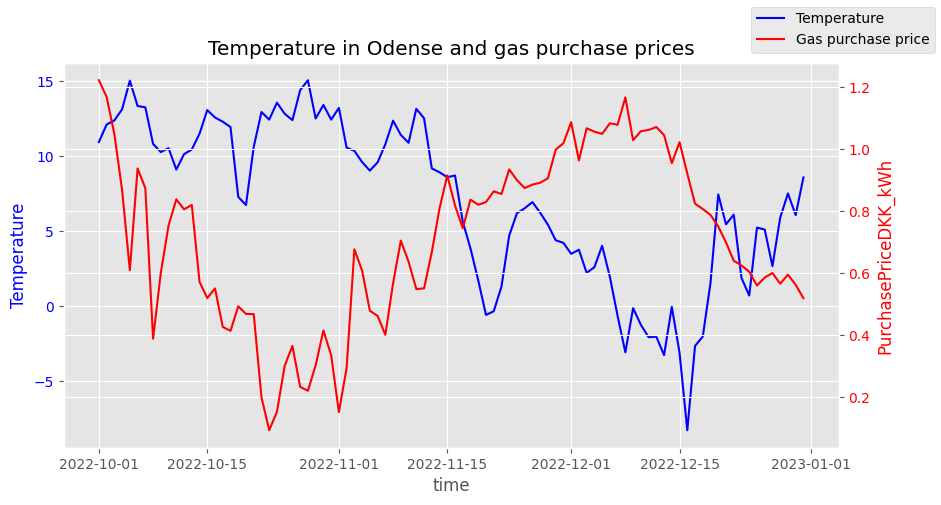

In [198]:
random.seed(1234341)  # Setting the seed for reproducability

# Choose a random municipality
rand_municipality = random.choice(df_weather_data_c["municipality"].unique())
df_random = sync_weather_to_gas(
    df_weather_data,
    df_gas_prices,
    "datetime",
    "GasDay",
    "temp",
    rand_municipality,
)

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting the temperatures
ax1.plot(df_random.index, df_random["temp"], color="b", label="Temperature")
ax1.set_xlabel("time")
ax1.set_ylabel("Temperature", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Plotting the gas purchase prices
ax2 = ax1.twinx()
ax2.plot(
    df_random.index,
    df_random["PurchasePriceDKK_kWh"],
    color="r",
    label="Gas purchase price",
)
ax2.set_ylabel("PurchasePriceDKK_kWh", color="r")
ax2.tick_params(axis="y", labelcolor="r")

fig.legend(loc="upper right")
plt.title(f"Temperature in {rand_municipality} and gas purchase prices")

plt.show()